## CONV2D Implementation

In [1]:
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
from functools import partial
from MiniTorch.core.baseclasses import ComputationNode
from MiniTorch.legacy_utils import _conv2d_forward_legacy_v1, _conv2d_forward_legacy_v2, _conv2d_backward_legacy_v1, _conv_initialize_legacy, get_kernel_size, get_stride, _conv2d_backward_legacy_v2
import time
from typing import Literal, List, Tuple, Dict, Any
import jax

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

In [54]:
class Conv2D(ComputationNode):

    def __init__(self, input_channels : int,kernel_size : int | tuple = 3, no_of_filters = 1, stride = 1, pad = 0, accumulate_grad_norm = False, accumulate_params = False,seed_key = None, bias = True, 
                 initialization = "None", use_legacy_v1 : bool = False, use_legacy_v2:bool = False):
        super().__init__()
        if seed_key == None:
            self.seed_key = jrandom.PRNGKey(int(time.time()))
        self.kernel_size = get_kernel_size(kernel_size)
        self.input_channels = input_channels
        self.no_of_filters = no_of_filters
        self.stride = get_stride(stride)
        self.pad = pad
        self.accumulate_grad_norm = accumulate_grad_norm
        self.accumulate_params = accumulate_params
        self.initialization = initialization
        self.parameters = {'W': None, 'b': None}
        self.bias = bias

        self.use_legacy_v1 = use_legacy_v1
        self.use_legacy_v2 = use_legacy_v2
        if use_legacy_v1 or use_legacy_v2:
            self.parameters['W'], self.parameters['b'] = _conv_initialize_legacy(self.kernel_size,self.no_of_filters,self.input_channels,self.initialization,self.bias)
        else:
            self.initialize(self.seed_key)
    def initialize(self, seed_key):
        if self.initialization == "he":
            self.parameters['W'] = jrandom.normal(seed_key, (self.no_of_filters, self.input_channels, self.kernel_size[0], self.kernel_size[1])) * jnp.sqrt(2/(self.no_of_filters * self.kernel_size[0] * self.kernel_size[1]))
        else:
            self.parameters['W'] = jrandom.normal(seed_key, (self.no_of_filters, self.input_channels, self.kernel_size[0], self.kernel_size[1]))
        if self.bias:
            self.parameters['b'] = jnp.zeros((self.no_of_filters,))

    @staticmethod
    def _conv2d_forward(X : jax.Array, W : jax.Array,b :jax.Array, stride : tuple, padding: Literal['VALID','SAME'] = 'VALID'):

        # def conv_over_one_batch(X_vec, W_vec, stride, padding):

        #     if X_vec.ndim == 3:
        #         X_vec = X_vec[None,...]
        #     cvout = jax.lax.conv_general_dilated(X_vec,W_vec[None,...],window_strides=stride,padding=padding,
        #                                             dimension_numbers=('NCHW','OIHW','NCHW'))[0,0]
        #     return cvout
        # convout = jax.vmap(jax.vmap(conv_over_one_batch,in_axes=(None,0,None,None)), in_axes=(0,None,None,None))(X,W,stride,padding)
        convout = jax.lax.conv_general_dilated(
        lhs=X, 
        rhs=W, 
        window_strides=stride, 
        padding=padding, 
        dimension_numbers=('NCHW', 'OIHW', 'NCHW')
        )
        convout += b[None,:,None,None]
        return convout
    @staticmethod
    def _conv2d_backward(X : jax.Array, W : jax.Array, stride : tuple, padding: int, out_grad : jax.Array):
        dL_db = jnp.sum(out_grad, axis=(0,2,3))
        in_channel = X.shape[1]
        batch_size, out_channels, out_h, out_w = out_grad.shape
        kh, kw = W.shape[2], W.shape[3]
        dL_dinput = jnp.zeros_like(X)
        dL_dW = jnp.zeros_like(X)

        input_strided = jax.lax.conv_general_dilated_patches(
            X,
            (kh, kw),
            stride,
            padding='VALID',
            dimension_numbers=('NCHW','OIHW','NCHW')
        )
        input_strided = input_strided.reshape(batch_size,out_h,out_w,in_channel,kh,kw)
        input_strided = input_strided.reshape(batch_size, out_h, out_w, in_channel, kh, kw)
        dL_dW = jnp.einsum('bhwikl,bchw->cikl', input_strided, out_grad, optimize=True)

        out_grad_up = jnp.zeros((batch_size, out_channels, out_h * stride[0], out_w * stride[1]))
        out_grad_up = out_grad_up.at[:, :, ::stride[0], ::stride[1]].set(out_grad)
        out_grad_padded = jnp.pad(out_grad_up, ((0, 0), (0, 0), (padding + 1, padding + 1), (padding + 1, padding + 1)))
        W_rotated = jnp.rot90(W, 2, axes=(2, 3))
        dL_dinput = jnp.einsum('bohw,oikl->bihw', out_grad_padded, W_rotated, optimize=True)

        return dL_dW, dL_db, dL_dinput

    def forward(self, x):
        self.input = x
        if self.use_legacy_v1:
            x = np.pad(x,((0,0),(0,0),(self.pad,self.pad),(self.pad,self.pad)))
            self.output = _conv2d_forward_legacy_v1(self.parameters['W'], x, self.stride, self.parameters['b'])
            return self.output
        if self.use_legacy_v2:
            x = np.pad(x,((0,0),(0,0),(self.pad,self.pad),(self.pad,self.pad)))
            self.output = _conv2d_forward_legacy_v2(self.parameters['W'], x, self.stride, self.parameters['b'])
            return self.output
        W, b, stride = self.parameters['W'], self.parameters['b'], self.stride
        with jax.checking_leaks():
            output = jax.jit(Conv2D._conv2d_forward, static_argnames=('stride','padding'))(x, W,b, stride)            
        self.output = output
        return self.output
    def backward(self, out_grad):
        dL_dW,dL_db,dL_dinput = None,None,None
        if self.use_legacy_v1:
            dL_dW,dL_db,dL_dinput = _conv2d_backward_legacy_v1(out_grad,self.input,self.kernel_size,self.parameters['W'],self.parameters['b'],self.stride,self.pad)
        elif self.use_legacy_v2:
            dL_dW,dL_db,dL_dinput = _conv2d_backward_legacy_v2(out_grad,self.input,self.kernel_size,self.parameters['W'],self.parameters['b'],self.stride,self.pad)
        else:
            input, W, b, stride,pad =self.input, self.parameters['W'], self.parameters['b'], self.stride, self.pad
            if self.pad:
                input = jnp.pad(self.input,((0,0),(0,0),(self.pad,self.pad),(self.pad,self.pad)))
            dL_dW,dL_db,dL_dinput = jax.jit(Conv2D._conv2d_backward,static_argnames=('stride','padding'))(input, W, stride, self.pad, out_grad)
            if self.pad:
                dL_dinput = dL_dinput[:,:,pad:-pad,pad:-pad]

        self.grad_cache['dL_dW'] = dL_dW
        self.grad_cache['dL_db'] = dL_db
        self.grad_cache['dL_dinput'] = dL_dinput
        return dL_dinput
    
    def weights_var_mean(self):
        return self.parameters['W'].var(), self.parameters['W'].mean()

    def bias_var_mean(self):
        return self.parameters['b'].var(), self.parameters['b'].mean()

    def step(self, lr):
        if self.accumulate_grad_norm:
            self._accumulate_grad_norm('dL_dW')
            self._accumulate_grad_norm('dL_db')
        if self.accumulate_params:
            self._accumulate_parameters('W', self.weights_var_mean)
            self._accumulate_parameters('b', self.bias_var_mean)
        self.parameters['W'] -= lr * self.grad_cache['dL_dW']
        if self.bias:
            self.parameters['b'] -= lr * self.grad_cache['dL_db']

In [ ]:
class Flatten(ComputationNode):
    def __init__(self):
        super().__init__()
        self.requires_grad = False
        self.shape = None

    def forward(self,x):
        self.shape = x.shape
        self.input = x
        self.output = jnp.reshape(x,(x.shape[0],-1))
        return self.output
    def backward(self, output_grad):
        dL_dinput= jnp.reshape(output_grad,(self.shape[0],self.shape[1],self.shape[2],self.shape[3]))
        self.grad_cache['dL_dinput']  = dL_dinput
        return dL_dinput
    
class MaxPool2d(ComputationNode):
    def __init__(self, pool_size, pool_stride, use_legacy_v1 = False):
        super().__init__()
        self.pool_size = get_kernel_size(pool_size)
        self.stride = get_stride(pool_stride)
        self.use_legacy_v1 = use_legacy_v1
        self.max_indices = None

        
    @staticmethod
    @partial(jax.jit, static_argnums=(0, 1))
    def _maxpool2d_forward(pool_size, stride, input):
        batch_size, in_channels, in_h, in_w = input.shape
        kh, kw = pool_size
        stride_h, stride_w = stride
        out_h = (in_h - kh) // stride_h + 1
        out_w = (in_w - kw) // stride_w + 1

        input_strided = jax.lax.conv_general_dilated_patches(
            input,
            filter_shape=(kh, kw),
            window_strides=(stride_h, stride_w),
            padding=((0, 0), (0, 0)),
            dimension_numbers=('NCHW', 'OIHW', 'NCHW')
        )  # (batch_size, in_channels, out_h, out_w, kh, kw)
        input_strided = input_strided.reshape(batch_size, in_channels, out_h, out_w, kh, kw)
        # Compute max and argmax over window dims (kh, kw)
        output = jnp.max(input_strided, axis=(4, 5))  # (batch_size, in_channels, out_h, out_w)
        max_indices = jnp.argmax(input_strided.reshape(*input_strided.shape[:4], -1), axis=-1)
        # (batch_size, in_channels, out_h, out_w) - flat indices in kh*kw

        return output, max_indices

    @staticmethod
    @partial(jax.jit, static_argnums=(0, 1))
    def _maxpool2d_backward(pool_size, stride, input, out_grad, max_indices):
        batch_size, in_channels, in_h, in_w = input.shape
        kh, kw = pool_size
        stride_h, stride_w = stride
        out_h, out_w = out_grad.shape[2], out_grad.shape[3]

        # Convert flat max_indices to 2D offsets within each window
        max_h_offsets = max_indices // kw  # finds the row offset, wehn you flatten in the forward pass the last two dimensions (kh,kw), the max indices range from (0,kw*kh-1), and you divide by kw to ge the row
        max_w_offsets = max_indices % kw   # finds the column offset of each index within a kernel, basically modulo by kw gives the column index within the kernel, like if max_idx  = 5 and k_w = 3 then the row_idx = 5//3 = 1 and col_idx 5%3 = 2

        # Compute input positions where max occurred
        h_starts = jnp.arange(out_h) * stride_h
        w_starts = jnp.arange(out_w) * stride_w
        h_pos = h_starts[None, None, :, None] + max_h_offsets[..., None]  # (b, c, h, w, 1)
        w_pos = w_starts[None, None, :, None] + max_w_offsets[..., None]  # (b, c, h, w, 1)

        # Flatten positions for scattering
        h_pos = h_pos.reshape(-1)
        w_pos = w_pos.reshape(-1)
        batch_idx = jnp.repeat(jnp.arange(batch_size), in_channels * out_h * out_w)
        chan_idx = jnp.tile(jnp.repeat(jnp.arange(in_channels), out_h * out_w), batch_size)
        out_grad_flat = out_grad.reshape(-1)

        # Scatter gradients to dL_dinput
        dL_dinput = jnp.zeros_like(input)
        indices = (batch_idx, chan_idx, h_pos, w_pos)
        print(indices)
        dL_dinput = dL_dinput.at[indices].add(out_grad_flat)

        return dL_dinput

    def forward(self, x):
        self.input = x
        if self.use_legacy_v1:
            output = self._maxpool2d_forward_legacy_v1(self.pool_size, self.stride, x)
            self.output = output
            self.max_indices = None  # Legacy doesn’t cache indices
        else:
            output, max_indices = self._maxpool2d_forward(self.pool_size, self.stride, x)
            self.output = output
            self.max_indices = max_indices
        return output

    def backward(self, output_grad):
        if self.use_legacy_v1:
            dL_dinput = self._maxpool2d_backward_legacy_v1(self.pool_size, self.input, output_grad, self.stride)
        else:
            dL_dinput = self._maxpool2d_backward(self.pool_size, self.stride, self.input, output_grad, self.max_indices)
        self.grad_cache = {'dL_input': dL_dinput}  # Assuming ComputationNode expects this
        return dL_dinput


In [90]:
x = np.random.randn(2,3,30,30)

In [91]:
conv = Conv2D(input_channels=3,kernel_size = 3, no_of_filters = 50, stride = 1, pad = 0, accumulate_grad_norm = False, accumulate_params = False,seed_key = None, bias = True, initialization = "None")
max_pool = MaxPool2d(2,1)
flatten = Flatten()

In [ ]:
st = time.time()
out = conv.forward(x)
out = max_pool.forward(out)
out = flatten.forward(out)
et = time.time()
et-st

(2, 50, 28, 28)
(2, 50, 27, 27)
(2, 36450)


0.03697681427001953

In [94]:
grad = np.random.randn(*list(out.shape))

In [ ]:
st = time.time()
grad1 = flatten.backward(grad)
grad2 = max_pool.backward(grad1)
in_grad1= conv.backward(grad2)
et = time.time()
et-st

(2, 50, 27, 27)
(Traced<ShapedArray(int32[72900])>with<DynamicJaxprTrace>, Traced<ShapedArray(int32[72900])>with<DynamicJaxprTrace>, Traced<ShapedArray(int32[72900])>with<DynamicJaxprTrace>, Traced<ShapedArray(int32[72900])>with<DynamicJaxprTrace>)


0.15452051162719727

## LRP for Conv2D

In [1]:
from MiniTorch.nets.base import Net
from MiniTorch.nets.layers import Conv2D, Linear, Flatten, ReLU, SoftMax
from MiniTorch.optimizers import SGD
from MiniTorch.losses import CCE
from MiniTorch.inference.core_infer import LRP
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

In [3]:
def get_training_data(X,Y,train_size):
    X_tra = X[:train_size]
    Y_tra = Y[:train_size]
    Y_tra = [[1 if j == int(i) else 0 for j in range(10)] for i in Y_tra]
    Y_tra = jnp.array(Y_tra)
    X_tra = jnp.reshape(jnp.array(X_tra),(train_size, 28,28))
    X_tra = jnp.expand_dims(X_tra,axis = 1)
    X_tra = X_tra.astype('float32')/255.
    return X_tra,Y_tra
X_tra, Y_tra = get_training_data(X,y,40000)

In [ ]:
X_t = X[40000:40000+5000]
Y_t = y[40000:40000+5000]
Y_t = [[1 if j == int(i) else 0 for j in range(10)] for i in Y_t]
Y_t = jnp.array(Y_t)
X_t = jnp.reshape(jnp.array(X_t),(5000, 28,28))
X_t = jnp.expand_dims(X_t,axis = 1)
X_t = X_t.astype('float32')/255.

In [4]:
net = Net(
    [
        Conv2D(1,4,15,stride=2),
        Flatten(),
        Linear(2535, 50),
        ReLU(),
        Linear(50, 50),
        ReLU(),
        Linear(50, 10),
        SoftMax()
    ],
    reproducibility_key=20
)

In [5]:
def yield_batches(X, Y, batch_size):
    n_samples = X.shape[0]
    assert n_samples == Y.shape[0], "Number of samples in X and Y must match"
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        yield X[start_idx:end_idx], Y[start_idx:end_idx]

In [8]:
epochs = 10
batch_size = 1000
crit = CCE()
optimizer = SGD(0.0001,net)

In [9]:
for epoch in range(epochs):
    epoch_loss = 0
    for X_train, Y_train in yield_batches(X_tra,Y_tra,batch_size):
        pred = net.forward(X_train)
        loss = crit.loss(pred,Y_train)
        ini_grad = crit.backward(loss)
        optimizer.step(ini_grad)
        epoch_loss += loss
    print(f"Loss for {epoch}/{epochs} -> {epoch_loss/1000}")

Loss for 0/10 -> 0.3930978775024414
Loss for 1/10 -> 0.39064279198646545
Loss for 2/10 -> 0.3892880082130432
Loss for 3/10 -> 0.3891879618167877
Loss for 4/10 -> 0.3924449682235718
Loss for 5/10 -> 0.3899584114551544
Loss for 6/10 -> 0.39679011702537537
Loss for 7/10 -> 0.3950413167476654
Loss for 8/10 -> 0.394601434469223
Loss for 9/10 -> 0.38911089301109314


In [6]:
net.load_model("modelcnn.pkl")

In [10]:
net.save_model("modelcnn.pkl")

In [25]:
X_tra.shape

(40000, 1, 28, 28)

In [36]:
sample = jnp.expand_dims(X_tra[-2],axis=0)
out = net.forward(sample)

O = jnp.expand_dims(net.layers[-2].output[0],axis=0)
R = jnp.zeros_like(O)
R = R.at[0,7].set(O[0,7])

In [39]:
jnp.argmax(O)

Array(7, dtype=int32)

In [10]:
class LRP:

    def __init__(self, net : Net, lrp_params:list, lrp_for_last_activation=False):
        self.net = net
        self.use_last_activ = lrp_for_last_activation
        self.lrp_params = lrp_params
        self.Rs = []
    def propagate_relevance_for_sample(self, R):
        for layer, lrp_param in zip(reversed(self.net.layers), self.lrp_params):
            if isinstance(layer, Linear):
                R = layer.lrp_backward(R,lrp_param["type"], **lrp_param)
                
            elif isinstance(layer, ReLU) or isinstance(layer, Flatten):
                R = layer.lrp_backward(R)
            elif isinstance(layer, Conv2D):
                R = layer.lrp_backward(R,lrp_param["type"], **lrp_param)
            self.Rs.append(R)
        return R

In [13]:
params = [{},{"type":0,"bias":False,"z_ep":0.1},{},{"type":1,"bias":False,"w_ep":0.1},{},{"type":0,"bias":False},{},{"type":1,"bias":False,"stride":(2,2)}]
lrp = LRP(net,params)

In [37]:
R_in = lrp.propagate_relevance_for_sample(R)

In [16]:
# R = lrp.Rs[-2]
W = net.layers[0].parameters['W']
input = net.layers[0].input
stride = (2,2)
print("R shape", R_in.shape, ", W Shape", W.shape, ", input shape", input.shape)

R shape (1, 1, 28, 28) , W Shape (15, 1, 4, 4) , input shape (1, 1, 28, 28)


In [40]:
B, C, H, W_in = input.shape
F, _, KH, KW = W.shape
_, _, OH, OW = (1, 15, 13, 13)
sh, sw = stride

In [41]:
patches = jax.lax.conv_general_dilated_patches(
        input,
        filter_shape=(KH, KW),
        window_strides=stride,
        padding='VALID',
        dimension_numbers=('NCHW', 'OIHW', 'NCHW')
    )
print("Shape after patching", patches.shape)
patches = patches.reshape(B, OH, OW, C, KH, KW)
print("Shape after reshaping", patches.shape)

Shape after patching (1, 16, 13, 13)
Shape after reshaping (1, 13, 13, 1, 4, 4)


In [21]:
b = net.layers[0].parameters['b']
b.shape

(15,)

In [22]:
z = jnp.einsum('bhwckl,fckl->bfhw',patches,W) + b[None,:,None,None]

In [25]:
from MiniTorch.plotutils import show_conv_out

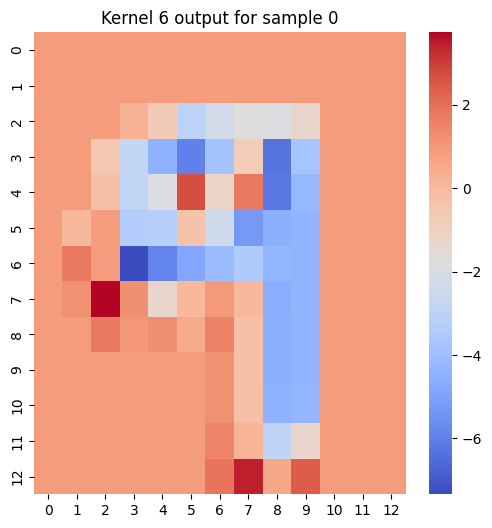

In [33]:
show_conv_out(net.layers[0],0,6)

In [24]:
def debug_conv_mismatch(layer, X):
    # ensure jnp arrays
    X = jnp.array(X)
    W = layer.parameters['W']
    b = layer.parameters['b'] if layer.bias else jnp.zeros((W.shape[0],), dtype=W.dtype)
    stride = layer.stride
    pad = layer.pad

    # make padded input exactly like layer.forward does
    if pad:
        X_padded = jnp.pad(X, ((0,0),(0,0),(pad,pad),(pad,pad)))
        padding_for_lax = 'VALID'
    else:
        X_padded = X
        padding_for_lax = 'VALID'  # matches your _conv2d_forward default

    # 1) ground truth using lax.conv_general_dilated
    z_lax = jax.lax.conv_general_dilated(
        lhs=X_padded,
        rhs=W,
        window_strides=stride,
        padding=padding_for_lax,
        dimension_numbers=('NCHW','OIHW','NCHW')
    )
    z_lax = z_lax + b[None, :, None, None]

    # 2) patches via conv_general_dilated_patches -> reshape -> einsum
    kh, kw = W.shape[2], W.shape[3]
    patches = jax.lax.conv_general_dilated_patches(
        X_padded,
        (kh, kw),
        stride,
        padding='VALID',   # patches assume we already handled padding externally
        dimension_numbers=('NCHW','OIHW','NCHW')
    )
    # conv_general_dilated_patches returns (B, OH, OW, C*kh*kw) on many builds
    B = X.shape[0]
    OH, OW = z_lax.shape[2], z_lax.shape[3]
    C = X.shape[1]
    patches = patches.reshape(B, OH, OW, C, kh, kw)

    z_einsum = jnp.einsum('b o p c k l, f c k l -> b f o p', patches, W)
    z_einsum = z_einsum + b[None, :, None, None]

    # numeric diffs
    abs_diff = jnp.max(jnp.abs(z_lax - z_einsum))
    print("max abs diff (lax vs einsum):", float(abs_diff))

    # sample the element you reported (example index from you)
    idx = (0, 0, 0, 2)  # (batch, filter, out_h, out_w) -> adjust if needed
    print("z_lax[idx]:", float(z_lax[idx]))
    print("z_einsum[idx]:", float(z_einsum[idx]))

    # print the patch contributing to that element and weight product
    b_idx, f_idx, o_idx, p_idx = idx
    patch = patches[b_idx, o_idx, p_idx]   # shape (C, kh, kw)
    weight = W[f_idx]                      # shape (C, kh, kw)
    prod = patch * weight
    summed = jnp.sum(prod)
    print("sum(patch*weight):", float(summed))
    print("bias for filter:", float(b[f_idx]))
    print("sum + bias (should equal z_lax element):", float(summed + b[f_idx]))

    # also print small diagnostics: shapes and dtypes
    print("shapes: X", X.shape, "X_padded", X_padded.shape, "W", W.shape, "z_lax", z_lax.shape)
    print("dtypes: X", X.dtype, "W", W.dtype, "z_lax", z_lax.dtype)

    return z_lax, z_einsum, patches

# Usage:
z_lax, z_einsum, patches = debug_conv_mismatch(net.layers[0], input)

max abs diff (lax vs einsum): 16.535255432128906
z_lax[idx]: 0.013321664184331894
z_einsum[idx]: -0.08180283010005951
sum(patch*weight): -0.0951244980096817
bias for filter: 0.013321664184331894
sum + bias (should equal z_lax element): -0.08180283010005951
shapes: X (1, 1, 28, 28) X_padded (1, 1, 28, 28) W (15, 1, 4, 4) z_lax (1, 15, 13, 13)
dtypes: X float32 W float32 z_lax float32


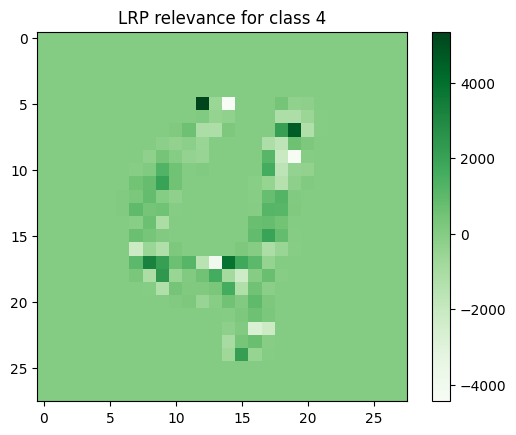

In [11]:
R_image = R_in.reshape(28, 28)
plt.imshow(R_image, cmap='Greens')
plt.title(f'LRP relevance for class {int(jnp.argmax(O))}')
plt.colorbar()
plt.show()

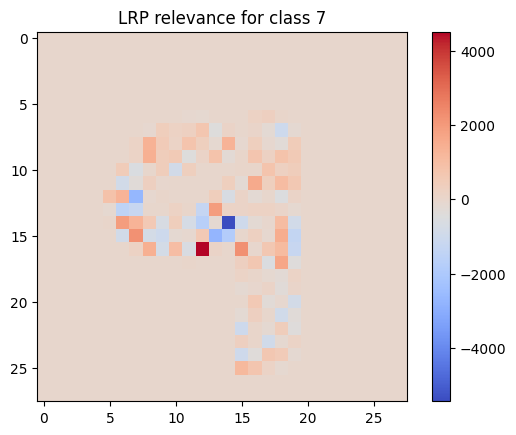

In [38]:
R_image = R_in.reshape(28, 28)
plt.imshow(R_image, cmap='coolwarm')
plt.title(f'LRP relevance for class {int(jnp.argmax(O))}')
plt.colorbar()
plt.show()

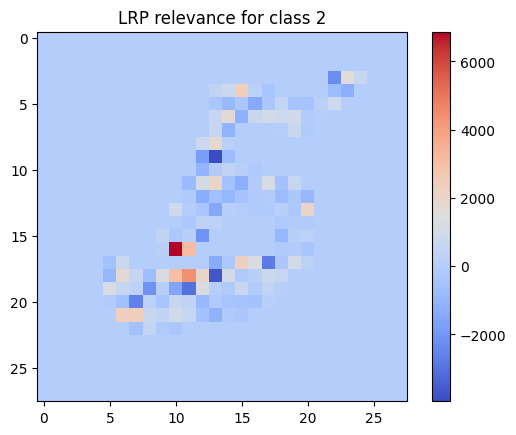

In [20]:
R_image = R_in.reshape(28, 28)
plt.imshow(R_image, cmap='coolwarm')
plt.title(f'LRP relevance for class {int(jnp.argmax(O))}')
plt.colorbar()
plt.show()

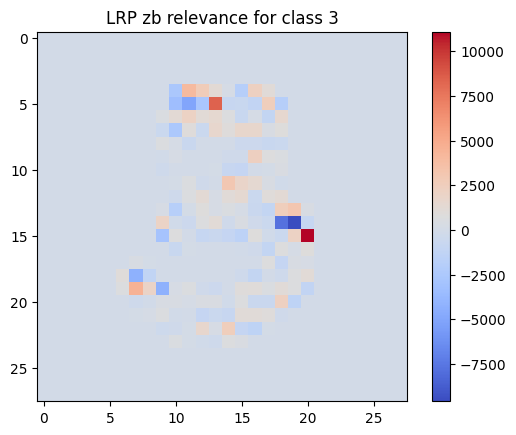

In [12]:
R_image = R_in.reshape(28, 28)
plt.imshow(R_image, cmap='coolwarm')
plt.title(f'LRP zb relevance for class {int(jnp.argmax(O))}')
plt.colorbar()
plt.show()

In [12]:
jnp.sum(R_in)

Array(24908.969, dtype=float32)